In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
from skimage.feature import hog
import os
%matplotlib inline

In [2]:


basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []

for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of vehicle images = ', len(cars))
with open('cars.txt', 'w') as f:
    for car in cars:
        f.write(car+'\n')

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []

for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of Non-vehicle images = ', len(notcars))
with open('notcars.txt', 'w') as f:
    for ncar in notcars:
        f.write(ncar+'\n')


Number of vehicle images =  8792
Number of Non-vehicle images =  8968


In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,
                     feature_vec=True):                         
    if vis:
        hog_features, hog_image = hog(img, orientations=orient,
                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block),                     
                      visualise= vis, feature_vector = feature_vec)    
        return hog_features, hog_image
    else:
        hog_features= hog(img, orientations=orient,
                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block),                     
                      visualise= vis, feature_vector = feature_vec)    
        #print('hog_features shape= ')
        #print(hog_features.shape)
        return hog_features

(64, 64, 3)


C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


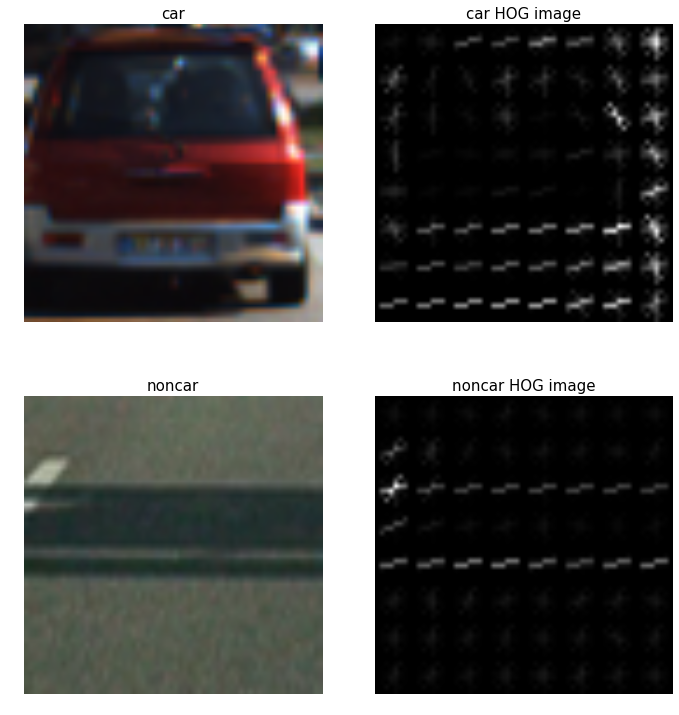

In [4]:
#read an image from car list and an image noncar list
#visualize the image and the corresponding features
n_orient = 9
n_pix_cell = 8
n_cell_blk = 2
hog_channel = 1

car_file = cars[np.random.randint(0,len(cars))]
notcar_file = notcars[np.random.randint(0,len(notcars))]

car_img = mpimg.imread(car_file)
print(car_img.shape)
noncar_img = mpimg.imread(notcar_file)

car_features, car_hog_img = get_hog_features(car_img[:,:, hog_channel], n_orient, n_pix_cell, n_cell_blk, vis=True, feature_vec=True)
noncar_features, noncar_hog_img = get_hog_features(noncar_img[:,:, hog_channel], n_orient, n_pix_cell, n_cell_blk, 
                                                   vis=True, feature_vec=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 12))
fig.subplots_adjust(hspace = 0.25, wspace=0.1)
ax1.axis('off')
ax1.set_title('car', fontsize=15)
ax1.imshow(car_img)
ax2.axis('off')
ax2.set_title('car HOG image', fontsize=15)
ax2.imshow(car_hog_img, cmap='gray')
ax3.axis('off')
ax3.set_title('noncar', fontsize=15)
ax3.imshow(noncar_img)
ax4.axis('off')
ax4.set_title('noncar HOG image', fontsize=15)
ax4.imshow(noncar_hog_img, cmap='gray')

In [5]:
def bin_spatial_orig(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [6]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1,color2,color3))

In [7]:
def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    #bin_edges = rhist[1]
    #bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features


In [8]:
def extract_features(img_filenames, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient = 9,
                        pix_per_cell = 8, cell_per_block = 2, hog_channel=0,
                        spatial_feat = True, hist_feat=True,
                        hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    print_data = False
    # Iterate through the list of images
    for file in img_filenames:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = []
        if spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat:
            if hog_channel == 'ALL':
                hog_features=[]
                for channel in range(feature_image.shape[2]):
                    hog_features_for_channel= get_hog_features(feature_image[:,:,channel],
                                                       orient, pix_per_cell,
                                                       cell_per_block,
                                                       vis=False, feature_vec=True)
                    hog_features.append(hog_features_for_channel)
                hog_features = np.ravel(hog_features)
            else:
                hog_features=get_hog_features(feature_image[:,:,hog_channel],
                                                       orient, pix_per_cell,
                                                       cell_per_block,
                                                       vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        #
        if print_data:   
            print('printing data')
            print(spatial_features.shape)
            print(hist_features.shape)
            print(hog_features.shape)
            print_data = False
        #
        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [10]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
   
    
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        #9) Return concatenated array of features
        return np.concatenate(img_features)

In [12]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [13]:
def visualize(fig, rows, cols, imgs,  titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [14]:
import time
from sklearn.svm import LinearSVC

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_indices = np.random.randint(0, len(cars), n_samples)
test_cars = cars
test_notcars = notcars

print('extracting features')

car_features = extract_features(test_cars, cspace= color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient =orient, pix_per_cell = pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=hog_channel,
                               spatial_feat = spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, cspace= color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient =orient, pix_per_cell = pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=hog_channel,
                               spatial_feat = spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)


print(time.time()-t, 'seconds for features computation')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0,100)
X_train, X_test, y_train,y_test = train_test_split(scaled_X, y, test_size = 0.1, random_state=rand_state)


print('Using: ', 'orient= ',orient, ' pix per cell = ', pix_per_cell, ' cell per block= ', cell_per_block,
      ' spatial binning= ',spatial_size,
    'and', ' histogram bins = ', hist_bins)
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))



extracting features
92.73469996452332 seconds for features computation
Using:  orient=  9  pix per cell =  8  cell per block=  2  spatial binning=  (32, 32) and  histogram bins =  32
Feature vector length: 8460
25.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# Sliding window approach

0.5371787548065186 seconds to process one image while searching  57  windows
0.3770275115966797 seconds to process one image while searching  57  windows
0.358928918838501 seconds to process one image while searching  57  windows
0.3349146842956543 seconds to process one image while searching  57  windows
0.3318819999694824 seconds to process one image while searching  57  windows
0.33489036560058594 seconds to process one image while searching  57  windows


C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


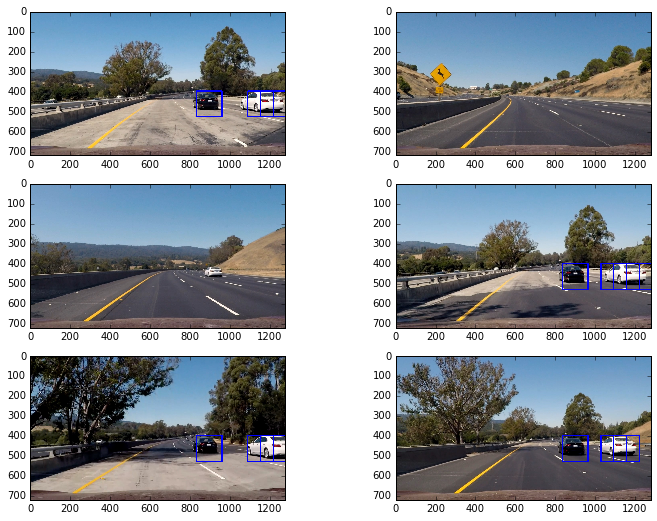

In [15]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

images= []
titles = []
y_start_stop= [400, 656]
overlap = 0.5
for img_path in example_images:
    t1 = time.time()
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(128,128), xy_overlap=(overlap,overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                               spatial_size=spatial_size, hist_bins= hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block= cell_per_block,hog_channel=hog_channel,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image while searching ',len(windows), ' windows')

fig=plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 6, 2, images, titles)    


#### Overlapping detections and False positives

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap


In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

0.4291403293609619 seconds to process one image while searching  57  windows
0.4341545104980469 seconds to process one image while searching  57  windows
0.4722614288330078 seconds to process one image while searching  57  windows
0.44217514991760254 seconds to process one image while searching  57  windows
0.5048518180847168 seconds to process one image while searching  57  windows
0.4055774211883545 seconds to process one image while searching  57  windows


C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


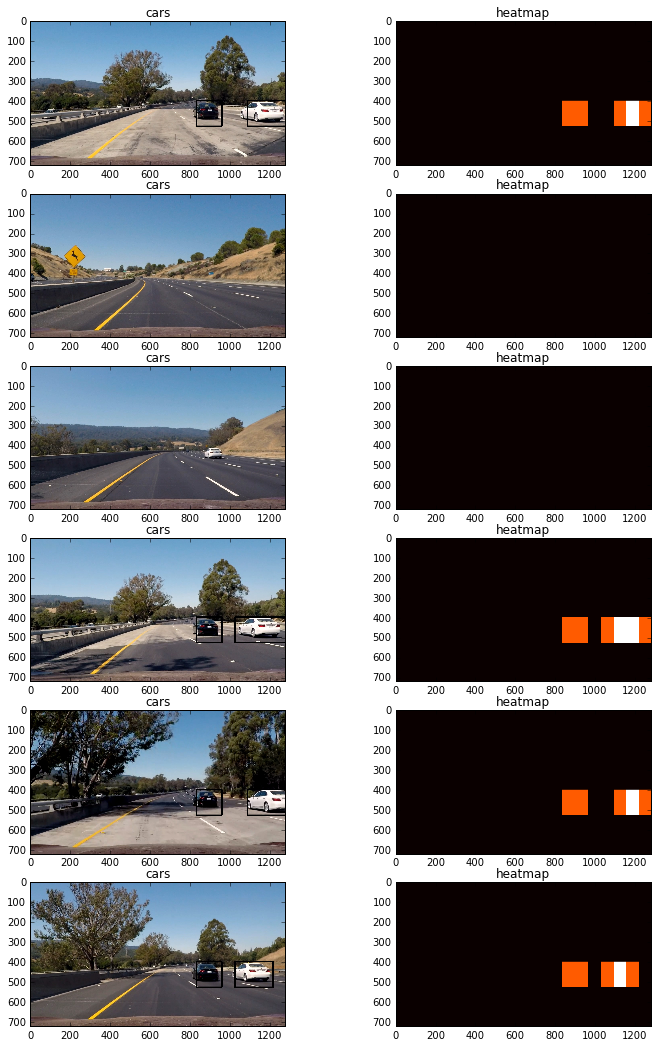

In [26]:
from scipy.ndimage.measurements import label

searchpath = 'test_images/*'
example_images = glob.glob(searchpath)

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

images= []
titles = []
y_start_stop= [400, 656]
overlap = 0.5
for img_path in example_images:
    t1 = time.time()
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(128,128), xy_overlap=(overlap,overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                               spatial_size=spatial_size, hist_bins= hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block= cell_per_block,hog_channel=hog_channel,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat, hog_feat=hog_feat)
    #window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)

    heatmap = apply_threshold(heatmap, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    images.append(draw_img)
    images.append(heatmap)
    titles.append('cars')
    titles.append('heatmap')
    print(time.time()-t1, 'seconds to process one image while searching ',len(windows), ' windows')

fig=plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 6, 2, images, titles)     
    
    
    

## HOG sub-sampling

In [27]:
def find_cars(img, scale = 1.0):    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32,32)
    hist_bins = 32
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    ystart = 400
    ystop = 656

    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    img_boxes=[]
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
     
            test_prediction = svc.predict(test_features)
            confidence = np.mean(svc.decision_function(test_features))
            if (test_prediction == 1.) and (confidence >= 0.30): #1.0, 0.45, 0.7
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                #append the detected car to the box list; used with heatmap.
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
                
    return draw_img, img_boxes
    

In [28]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [30]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(img)
        

C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


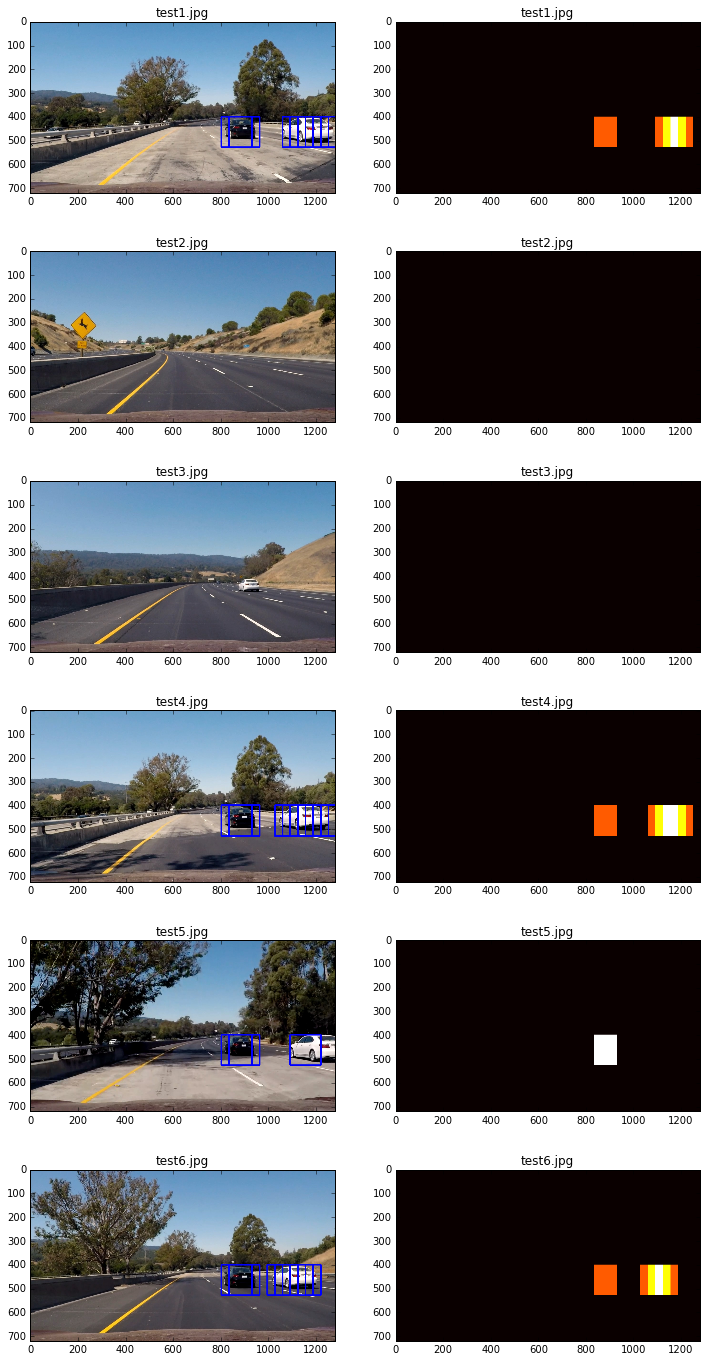

In [31]:
out_images=[]
out_maps = []
out_titles = []
scale = 2
examples_path = 'test_images/'
example_images= os.listdir(examples_path)
for img_src in example_images:
    if img_src.endswith(".png") or img_src.endswith(".jpg"):
        img = mpimg.imread(examples_path+img_src)
        
               
        out_img, boxes =  find_cars(img, scale)
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap, boxes)
        
        heatmap = apply_threshold(heatmap, 1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        draw_img = draw_boxes(np.copy(img), boxes, color=(0,0,255), thick=6)#draw_labeled_bboxes(np.copy(img), labels)
        
        out_images.append(draw_img)
        out_images.append(heatmap)
        out_titles.append(img_src)
        out_titles.append(img_src)
        

fig = plt.figure(figsize=(12,24))

visualize(fig, 6, 2, out_images, out_titles)    
    
    

#### Overlapping detections and False positives

C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


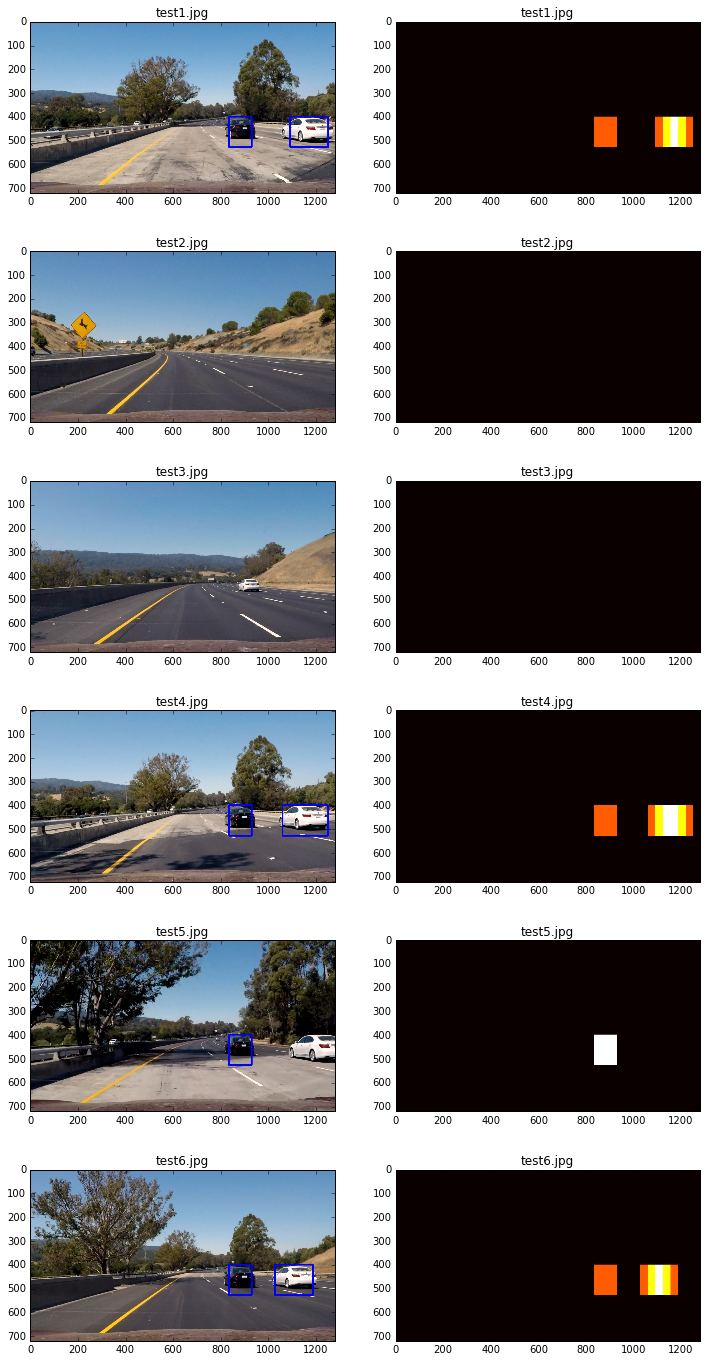

In [33]:
out_images=[]
out_maps = []
out_titles = []
scale = 2
examples_path = 'test_images/'
example_images= os.listdir(examples_path)
for img_src in example_images:
    if img_src.endswith(".png") or img_src.endswith(".jpg"):
        img = mpimg.imread(examples_path+img_src)
        
               
        out_img, boxes =  find_cars(img, scale)
        
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap, boxes)
        
        heatmap = apply_threshold(heatmap, 1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        out_images.append(draw_img)
        out_images.append(heatmap)
        out_titles.append(img_src)
        out_titles.append(img_src)
        

fig = plt.figure(figsize=(12,24))

visualize(fig, 6, 2, out_images, out_titles)    
    

In [42]:
def process_image(img):
    scale = 1.5
    out_img, boxes = find_cars(img, scale)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes)

    heatmap = apply_threshold(heatmap, 1)
        
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img


In [43]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
project_video_path = 'project_video.mp4'
output_video_path = 'project_video_output.mp4'
video = VideoFileClip(project_video_path)
output_video = video.fl_image(process_image)
%time output_video.write_videofile(output_video_path, audio=False)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:20<00:00,  2.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 10min 21s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))